## Training RESNET on CIFAR10 using DavidNet
#### Using DavidNet's final model & One-Cycle LR for SuperConvergence i.e. fast training

In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 142 (delta 82), reused 50 (delta 21), pack-reused 0
Receiving objects: 100% (142/142), 44.66 KiB | 586.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.4.6 is successfully installed


In [3]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

### Load CIFAR10 dataset with transforms from Albumentations applied

In [5]:
from pytorch_utils import dataset, datasetmgr, transforms
train, test = dataset.cifar10_albumentations()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/test_batch


In [6]:
SEED = 1
BATCH_SIZE = 512

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


### Visualize training dataset to verify the augmentations done on it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer truck   cat truck truck   cat   cat


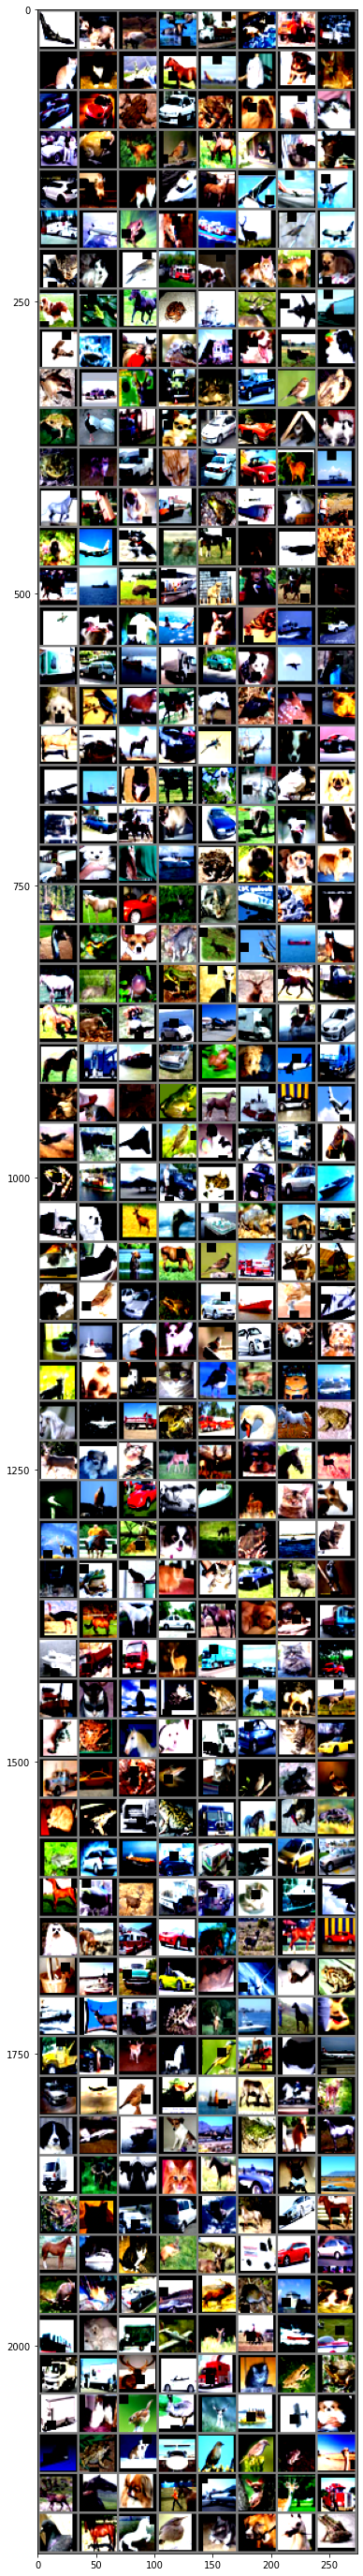

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
plt.figure(figsize = (50,50))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Import RESNET model for CIFAR10 dataset

In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_DAVID_RES_NET((3, 32, 32)).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

#### Peform LR range test to find max LR


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.75E-03


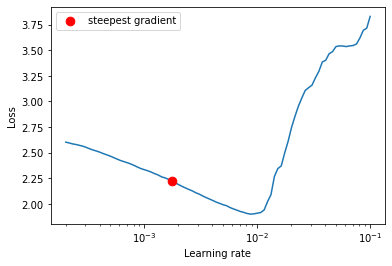

In [10]:
import torch.optim as optim
import torch.nn as nn

from pytorch_utils import lrfinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(net, optimizer, criterion, device)
lr_finder.range_test(trainloader, end_lr=1e-1, num_iter=100, step_mode="exp")
lr_finder.plot(skip_end=0)
lr_finder.reset() # restore the model and optimizer to their initial state

### Train the model with One-Cycle LR Policy

  0%|          | 0/98 [00:00<?, ?it/s]

Peak Steps: 490, Total Steps: 2352, Peak Percentage: 0.20833333333333334
EPOCH: 0


Loss=1.2735153436660767 Batch_id=97 Accuracy=38.75: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]


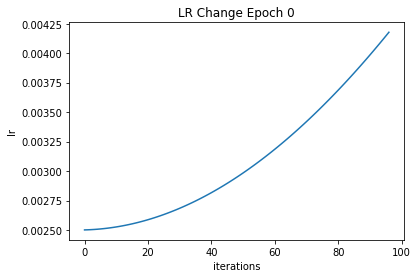

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 2604/5000 (52.08%)

EPOCH: 1


Loss=1.0397508144378662 Batch_id=97 Accuracy=60.32: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]


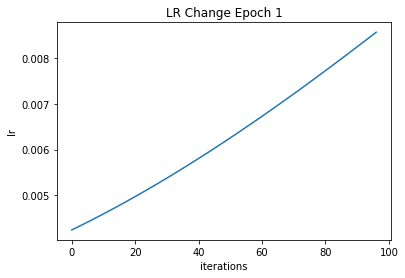

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 2840/5000 (56.80%)

EPOCH: 2


Loss=0.7896093726158142 Batch_id=97 Accuracy=70.64: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]


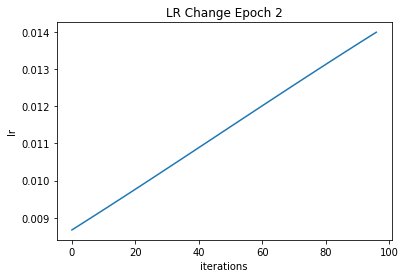

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 3578/5000 (71.56%)

EPOCH: 3


Loss=0.7280478477478027 Batch_id=97 Accuracy=75.67: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]


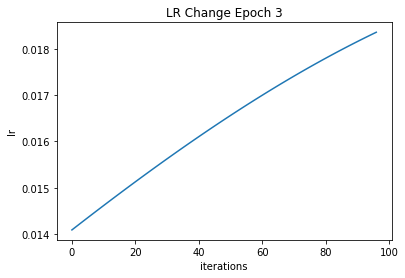

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 3887/5000 (77.74%)

EPOCH: 4


Loss=0.4393611252307892 Batch_id=97 Accuracy=80.11: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


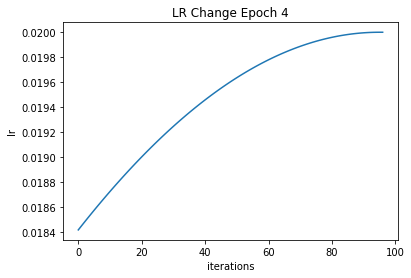

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 3713/5000 (74.26%)

EPOCH: 5


Loss=0.5103213787078857 Batch_id=97 Accuracy=82.78: 100%|██████████| 98/98 [00:27<00:00,  3.63it/s]


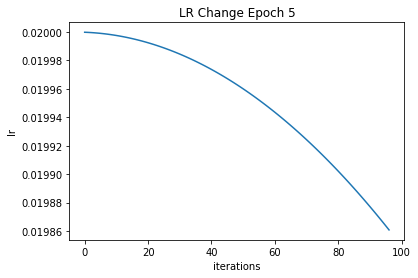

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 3805/5000 (76.10%)

EPOCH: 6


Loss=0.4548827111721039 Batch_id=97 Accuracy=84.59: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


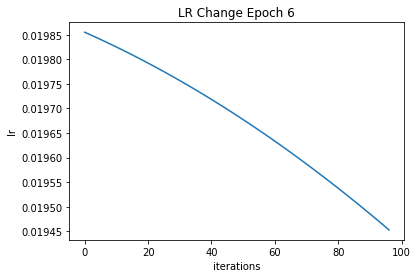

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 3977/5000 (79.54%)

EPOCH: 7


Loss=0.40529146790504456 Batch_id=97 Accuracy=86.35: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


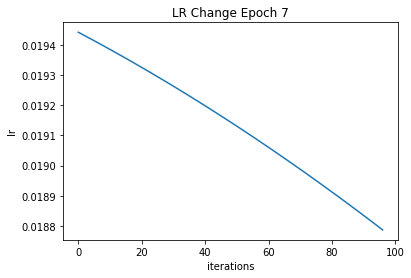

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 4122/5000 (82.44%)

EPOCH: 8


Loss=0.4353335201740265 Batch_id=97 Accuracy=87.33: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


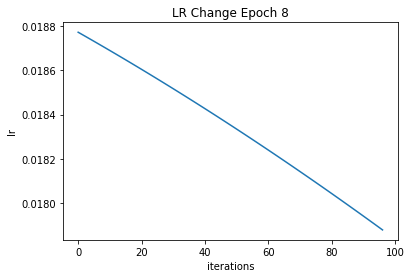

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 4321/5000 (86.42%)

EPOCH: 9


Loss=0.3740541934967041 Batch_id=97 Accuracy=88.37: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


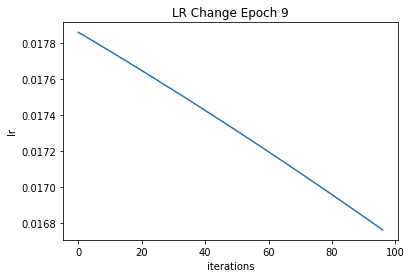

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 4143/5000 (82.86%)

EPOCH: 10


Loss=0.27157658338546753 Batch_id=97 Accuracy=89.52: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


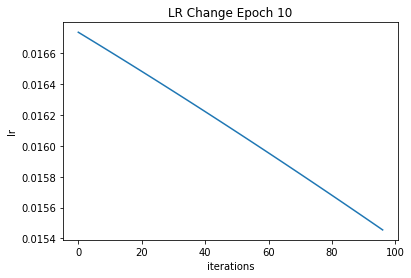

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 4332/5000 (86.64%)

EPOCH: 11


Loss=0.2615662217140198 Batch_id=97 Accuracy=89.80: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]


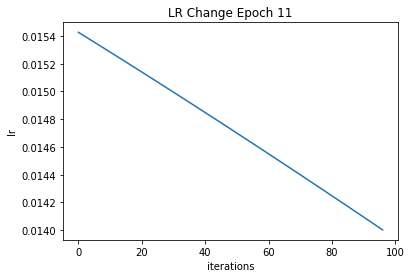

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 4272/5000 (85.44%)

EPOCH: 12


Loss=0.3195801377296448 Batch_id=97 Accuracy=90.90: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


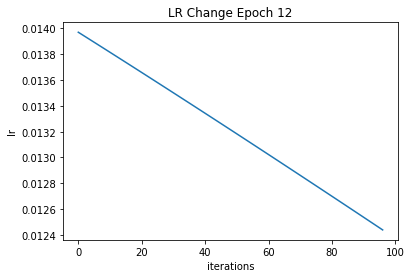

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 4259/5000 (85.18%)

EPOCH: 13


Loss=0.29866084456443787 Batch_id=97 Accuracy=91.20: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]


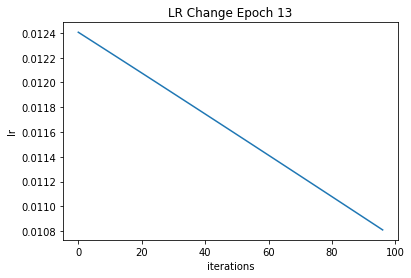

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 4096/5000 (81.92%)

EPOCH: 14


Loss=0.27836889028549194 Batch_id=97 Accuracy=92.42: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s]


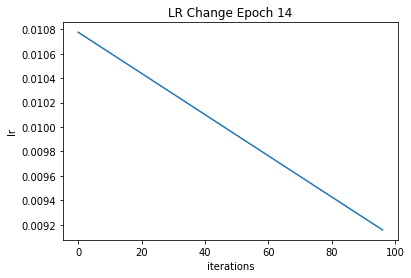

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 4246/5000 (84.92%)

EPOCH: 15


Loss=0.3024134933948517 Batch_id=97 Accuracy=92.80: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s]


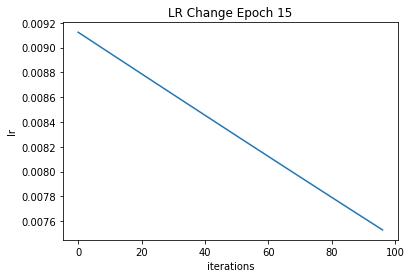

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 4351/5000 (87.02%)

EPOCH: 16


Loss=0.20937903225421906 Batch_id=97 Accuracy=93.80: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]


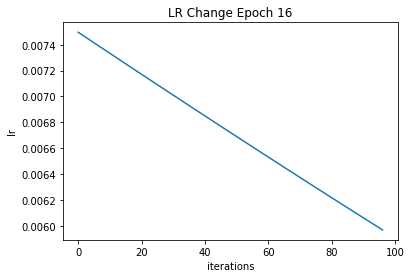

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 4332/5000 (86.64%)

EPOCH: 17


Loss=0.2198263555765152 Batch_id=97 Accuracy=94.28: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


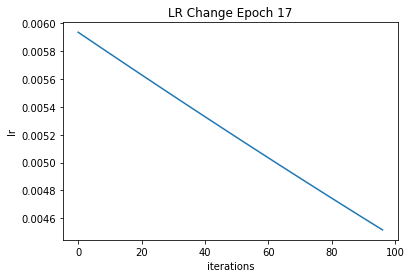

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 4533/5000 (90.66%)

EPOCH: 18


Loss=0.11046212911605835 Batch_id=97 Accuracy=95.44: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]


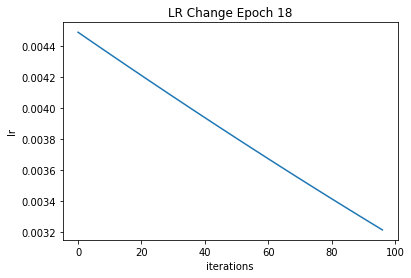

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 4523/5000 (90.46%)

EPOCH: 19


Loss=0.0927070900797844 Batch_id=97 Accuracy=96.44: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


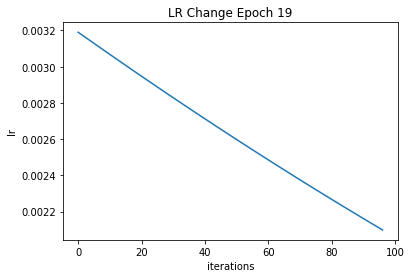

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 4571/5000 (91.42%)

EPOCH: 20


Loss=0.08659116178750992 Batch_id=97 Accuracy=97.33: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


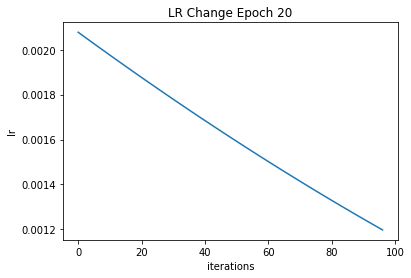

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 4643/5000 (92.86%)

EPOCH: 21


Loss=0.10098333656787872 Batch_id=97 Accuracy=98.04: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


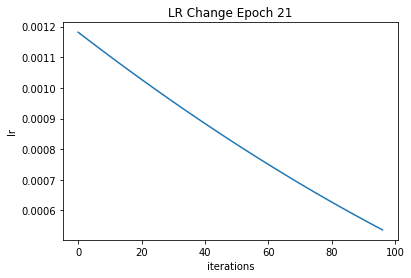

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 4661/5000 (93.22%)

EPOCH: 22


Loss=0.09383649379014969 Batch_id=97 Accuracy=98.49: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


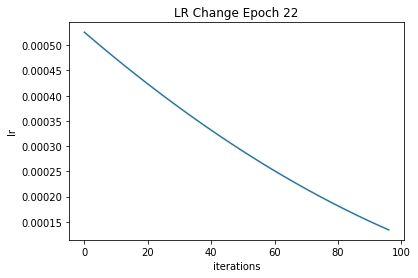

  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 4669/5000 (93.38%)

EPOCH: 23


Loss=0.07355668395757675 Batch_id=97 Accuracy=98.71: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s]


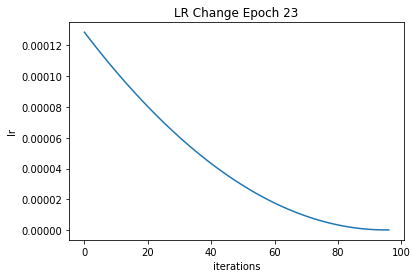


Test set: Average loss: 0.0004, Accuracy: 4667/5000 (93.34%)



In [11]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24
PEAK_EPOCH = 5

lr_max =2e-2
lr_min_div_factor = 8
steps_per_epoch = len(trainloader)
total_steps = EPOCHS * steps_per_epoch
peak_steps = PEAK_EPOCH * steps_per_epoch
peak_pct = peak_steps/total_steps
print(f"Peak Steps: {peak_steps}, Total Steps: {total_steps}, Peak Percentage: {peak_pct}")
scheduler = OneCycleLR(optimizer, max_lr=lr_max, div_factor=lr_min_div_factor,
                       steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                       pct_start=peak_pct)

model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict(), scheduler)
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

### Training & Test accuracy/loss graphs

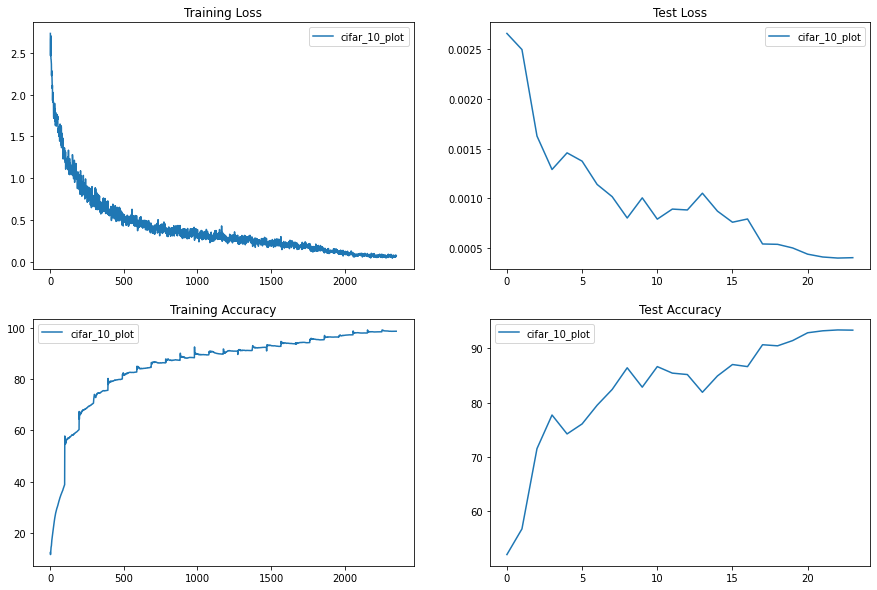

In [12]:
from pytorch_utils import utils

utils.plot_results(train_losses, train_acc, test_losses, test_acc)